In [ ]:
!mkdir -p-/.kaggle
!kaggle datasets download -d xying0613/pictures-of-animals-for-image-classification

mkdir: invalid option -- '-'
Try 'mkdir --help' for more information.
Dataset URL: https://www.kaggle.com/datasets/xying0613/pictures-of-animals-for-image-classification
License(s): unknown
pictures-of-animals-for-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/pictures-of-animals-for-image-classification.zip", 'r')
zip_ref.extractall("/content")


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import  preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Flatten, Dense,Dropout

# Load and preprocess data
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Animals",
    seed=123,
    image_size=(224, 224),
    batch_size=1
)

x, y = zip(*train_ds)
x = tf.concat(x, axis=0)
y = tf.concat(y, axis=0)

# Get the class names from the dataset
class_names = train_ds.class_names

# Find the index corresponding to 'cats'
cat_index = class_names.index('cats')

# Create binary labels using the cat_index
y_binary = np.where(y == cat_index, 1, 0)

# Split data into training and testing sets
training_ratio = 0.7 * len(x)
x_train, x_test = x[:int(training_ratio)], x[int(training_ratio):]
y_train, y_test = y_binary[:int(training_ratio)], y_binary[int(training_ratio):]


# Data augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

# Function to apply augmentation to cat images only
def augment_cat_images(image, label):
    if label == 1:  # 1 represents 'cat'
        image = data_augmentation(image)
    return image, label

# Apply augmentation to training data
# Convert x_train and y_train to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Apply augmentation to the dataset
augmented_train_ds = train_dataset.map(augment_cat_images)

# Get the augmented data
x_train_augmented, y_train_augmented = next(iter(augmented_train_ds.batch(len(x_train))))

# Preprocess images (after augmentation)
x_train_preprocessed = preprocess_input(x_train_augmented)
x_test_preprocessed = preprocess_input(x_test)

# Build the model using MobileNetV2 as the base
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),include_top=False,weights='imagenet')
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


model.summary()

Found 5002 files belonging to 10 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,056,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,381,380 (70.12 MB)

 Trainable params: 16,123,396 (61.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile the model
model.compile(optimizer = "adam" , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train_preprocessed, y_train, batch_size= 64, epochs = 10)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.9012 - loss: 2.0100
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9922 - loss: 0.1842
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9896 - loss: 0.1628
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.9948 - loss: 0.0754
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9963 - loss: 0.0707
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9947 - loss: 0.1334
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.9961 - loss: 0.0548
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9951 - loss: 0.0955
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.9953 - loss: 0.1100
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.9991 - loss: 0.0723


In [ ]:
Y_pred = model.predict(x_test_preprocessed)
print(y_test[:10])
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, Y_pred.argmax(axis=1))
print("Accuracy:", accuracy)

47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step
[0 0 0 1 0 0 0 0 0 0]
Accuracy: 0.9940039973351099


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


Y_pred = model.predict(x_test_preprocessed)
y_pred_classes = Y_pred.argmax(axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Precision: 0.9852941176470589
Recall: 0.950354609929078
F1-score: 0.9675090252707581


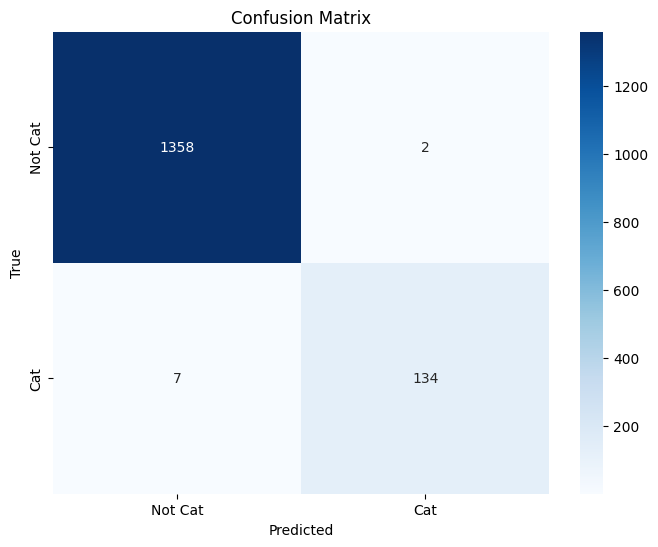

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_classes are defined from the previous code

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Cat', 'Cat'], yticklabels=['Not Cat', 'Cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()